In [1]:
# 필요한 모듈 import
import numpy as np
import pandas as pd
import os
import librosa
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import random

tqdm.pandas()

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.signal import resample

# 필요한 상수 정의
SAMPLE_RATE = 16000
FOLDER_NAME = "data"  # csv파일 생성할 폴더 이름
RESULTS_FILE_NAME = "voyager_test_results" # test 결과 파일

np.random.seed(0)
random.seed(0)

In [2]:
def get_test_file():
  file_name = open(f'202301ml_fmcc/fmcc_test_ref.txt', 'r')
  test_data_list = []
  label_list = []

  for i in file_name.readlines():
    file, label = i.strip('\n').split(' ')
    
    f = open(f'202301ml_fmcc/raw16k/test/' + file + '.raw', 'rb')
    file = np.fromfile(f, dtype='int16', sep="")
    
    test_data_list.append(file.astype(np.float32))
    label_list.append(0 if label[0] == 'm' else 1)
    
  return test_data_list, label_list

def get_train_file():
  file_name = open(f'202301ml_fmcc/fmcc_train.ctl', 'r')
  train_data_list = []
  label_list = []
  for i in file_name.readlines():
    i = i.strip('\n')
    f = open(f'202301ml_fmcc/raw16k/train/' + i + '.raw', 'rb')
    file = np.fromfile(f, dtype='int16', sep="")
    
    train_data_list.append(file.astype(np.float32))
    label_list.append(0 if i[0] == 'M' else 1)
        
    # add_noise_audio = file.astype(np.float32)
    # noise = np.random.normal(0, 500, add_noise_audio.shape)

    #원본 음성 데이터에 노이즈 추가
    # noisy_signal = add_noise_audio + noise
    # train_data_list.append(noisy_signal)
    # label_list.append(0 if i[0] == 'M' else 1)
    
    # extended_audio = file.astype(np.float32)
    # train_data_list.append(resample(extended_audio, int(len(extended_audio) / 2)))
    # label_list.append(0 if i[0] == 'M' else 1)
    
  return train_data_list, label_list

In [3]:
def get_mfcc(data): 
    ft1 = librosa.feature.mfcc(y=data, sr=SAMPLE_RATE, n_mfcc=20, fmin=0.0, fmax=500.0)
    # ft2 = librosa.feature.zero_crossing_rate(y = data)[0]
    # ft3 = librosa.feature.spectral_rolloff(y = data)[0]
    # ft4 = librosa.feature.spectral_centroid(y = data)[0]
    # ft5 = librosa.feature.spectral_contrast(y = data)[0]
    # ft6 = librosa.feature.spectral_bandwidth(y = data)[0]
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), kurtosis(ft1, axis=1), np.max(ft1, axis=1), np.median(ft1, axis=1), np.min(ft1, axis=1)))
    # ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    # ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    # ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    # ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    # ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    # return pd.Series(np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc)))
    return pd.Series(np.hstack((ft1_trunc,)))
    
def preprocess_data(data_list):
    feature_list = []
    for i in tqdm(range(len(data_list))):
        feature_list.append(get_mfcc(data_list[i]))
    return pd.DataFrame(feature_list)

In [4]:
try:
    os.mkdir(FOLDER_NAME)
    print(f"{FOLDER_NAME} 폴더가 성공적으로 생성되었습니다.")
except FileExistsError:
    print("이미 동일한 이름의 폴더가 존재합니다.")
except Exception as e:
    print("폴더 생성 중 오류가 발생했습니다:", str(e))

이미 동일한 이름의 폴더가 존재합니다.


In [5]:
try:
  print("csv 파일을 불러옵니다.")
  train_data_feature = pd.read_csv(f'{FOLDER_NAME}/train_data_feature.csv')
  test_data_feature = pd.read_csv(f'{FOLDER_NAME}/test_data_feature.csv')
  
  train_label = pd.read_csv(f'{FOLDER_NAME}/train_data_label.csv')
  test_label = pd.read_csv(f'{FOLDER_NAME}/test_data_label.csv')
except:
  print("csv 파일을 생성합니다.")
  train_data, train_label = get_train_file()
  test_data, test_label = get_test_file()

  train_data_feature = preprocess_data(train_data)
  test_data_feature = preprocess_data(test_data)
  
  train_data_feature.to_csv(f'{FOLDER_NAME}/train_data_feature.csv', index=False)
  test_data_feature.to_csv(f'{FOLDER_NAME}/test_data_feature.csv', index=False)
  
  pd.DataFrame(train_label).to_csv(f'{FOLDER_NAME}/train_data_label.csv', index=False)
  pd.DataFrame(test_label).to_csv(f'{FOLDER_NAME}/test_data_label.csv', index=False)
else:
  train_label = train_label.values.ravel()
  test_label = test_label.values.ravel()
finally:
  print("데이터 로드 완료")
  train_data_label = np.array(train_label)
  test_data_label = np.array(test_label)

csv 파일을 불러옵니다.
데이터 로드 완료


In [6]:
train_data_feature.shape
test_data_feature.shape

(900, 605)

In [7]:
# Apply scaling for PCA
scaler = StandardScaler()
train_x_pca = scaler.fit_transform(train_data_feature)
test_x_pca = scaler.fit_transform(test_data_feature)

In [8]:
# Fit an SVM model
clf = SVC(kernel='rbf', probability=True)
clf.fit(train_x_pca, train_data_label)

train_accuracy = accuracy_score(clf.predict(train_x_pca), train_data_label)
print(train_accuracy)

0.9928


In [9]:
test_accuracy = accuracy_score(clf.predict(test_x_pca), test_data_label)
print(test_accuracy)

0.9444444444444444


1. 원래 mfcc, nosie 추가
0.9022222222222223

2. 원래 mfcc, 음성 길이 증가
0.7577777777777778

3. 원래 mfcc, 음성 길이 감소
0.7433333333333333

4. 수정된 mfcc, noise 추가
0.9022222222222223

5. 수정된 mfcc
0.9044444444444445

In [10]:
file_name = open('fmcc_test_ref.txt', 'r')
test_file_name = []

for i in file_name.readlines():
    file, _ = i.strip('\n').split(' ')
    test_file_name.append(file)

def write_predictions(predictions, filename):
    with open(filename, 'w') as file:
        for index, pred in enumerate(predictions):
            file.write((f'{test_file_name[index]} ' + ('feml' if pred == 1 else 'male')) + '\n')

In [11]:
test_predictions = clf.predict(test_x_pca)
write_predictions(test_predictions, f'{RESULTS_FILE_NAME}.txt')

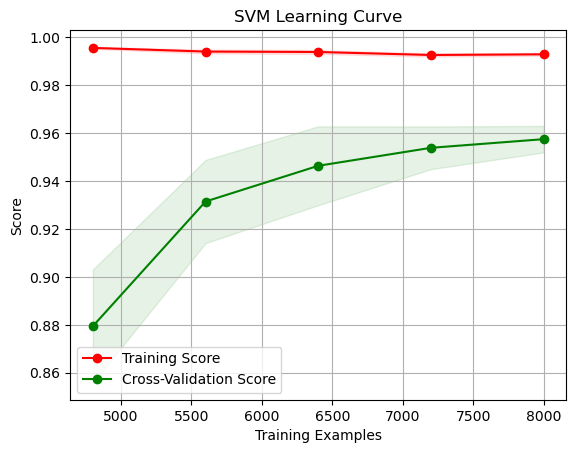

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Compute the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(clf, train_x_pca, train_data_label, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Compute the mean and standard deviation of training scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# Compute the mean and standard deviation of test scores
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("SVM Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

# Plot the training scores with error bars
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")

# Plot the cross-validation scores with error bars
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [13]:
train_sizes


array([ 800, 1600, 2400, 3200, 4000, 4800, 5600, 6400, 7200, 8000])

In [14]:
test_scores_mean

array([   nan,    nan,    nan,    nan,    nan, 0.8794, 0.9314, 0.9463,
       0.9538, 0.9574])